In [1461]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from typing import Dict, List, Set
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

In [1462]:
locations_synonyms: Dict[str, List[str]] = {
    "Warszawa": ["Warsaw", "Warszawa", "Katowice; Warszawa", "Warszawa (Centrum)", "Waraszawa"],
    "Kraków": ["Krakow", "Kraków"],
    "Wrocław": ["Wroclaw", "Wrocław"],
    "Poznań": ["Poznan", "Poznań", "Pozanań"],
    "Gdańsk": ["Gdansk", "Gdańsk"],
    "Szczecin": ["Szczecin", "szczecin"],
    "Łódź": ["Lodz", "Łódź"],
    "Rzeszów": ["Rzeszow", "Rzeszów"],
    "Katowice": ["Katowice", "Katowice; Warszawa"],
    "Kielce": ["Kielce"],
    "Opole": ["opole", "Opole"],
    "Sopot": ["Sopot"],
    "Olszytn": ["Olsztyn"],
    "Gdynia": ["Gdynia"],
}

location_encoder = LabelEncoder()
exp_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

# read data from json file
df = pd.read_json("../data/offers.json")

def replace_synonyms(locations):
    for standard, synonyms in locations_synonyms.items():
        for i, loc in enumerate(locations):
            if loc in synonyms:
                locations[i] = standard
    return locations

df["locations"] = df["locations"].apply(replace_synonyms)
df = df.explode("locations")
df["location"] = df["locations"]

df["location_code"] = location_encoder.fit_transform(df["location"])

df["experience_code"] = exp_encoder.fit_transform(df["experience"])
df["operating_mode_code"] = mode_encoder.fit_transform(df["operating_mode"])
df = df.drop(columns=["locations", "operating_mode", "experience", "location"])

mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('technologies')),
                          columns=mlb.classes_,
                          index=df.index))

df.to_csv("../data/offers_normalized_locations.csv", index=False)    


## Usuwanie niepotrzebnych danych

Na wszelki wypadek usuwam niepotrzebne dane, które mogą być niepotrzebne w przyszłości.
<p style="color: red">W przypadku ofert pracy gdzie nie ma definiowanych widełek dla np. b2b nie będę ich próbował wyliczać, bo nie ma to sensu, ponieważ zarobki zależą od technologi i poziomu doświadczenia.</p> 


In [1463]:
offers = pd.read_csv("../data/offers_normalized_locations.csv")

offers = offers.drop_duplicates()
offers = offers.dropna()

rows_to_drop = offers[((offers['max_uop'] < 1000) & (offers["max_uop"] > 0)) | ((offers['max_b2b'] < 1000) & (offers["max_b2b"] > 0))].index
offers = offers.drop(rows_to_drop)

offers.columns = offers.columns.str.strip()

offers.to_csv("../data/jobs.csv", index=False)

## Zapis i naprawa danych z formatu JSON do CSV.

Na początku tworze sobie synonimy dla najpopularniejszych nazw miast, ponieważ w niektórych przypadkach, 
miasta mają w sobie literówki np. `Waraszawa` albo nie obsłużyłem wystarczająco dużo przypadków przy miastach.
Następnie naprawiamy sobie lokacje oraz technologie. W przypadku technologii nie naprawam ich ponieważ mam pewność że są poprawne przez to ze były w jednym miejscu na stronie oraz po przejrzeniu ich nie znalazłem błędów.

# Szybki look na dane

In [1464]:
data = pd.read_csv('../data/jobs.csv')
df = pd.DataFrame(data)
# title,min_b2b,max_b2b,min_uop,max_uop,experience,operating_mode,experience_code,operating_mode_code
display(df.head())

,title,min_b2b,max_b2b,min_uop,max_uop,location_code,experience_code,operating_mode_code,AWS,Angular,...,React,Ruby,SQL,Scala,Spring,Terraform,TypeScript,Vue.js,Windows,android
0,Senior Software Engineer - Full Stack (JavaScr...,0,0,18000,28000,51,2,0,1,0,...,1,0,0,0,0,1,1,0,0,0
1,Senior Backend Node.js Engineer (remote),0,0,18360,25125,38,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0
2,Senior Backend Node.js Engineer (remote),0,0,18360,25125,17,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0
3,Senior Backend Node.js Engineer (remote),0,0,18360,25125,51,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0
4,Senior Backend Node.js Engineer (remote),0,0,18360,25125,55,2,2,0,0,...,1,0,0,0,0,0,1,0,0,0


In [1465]:
print(len(df))

4574


# Średnie zarobki na b2b dla juniora

In [1466]:
df[(df["min_b2b"] > 0) & (df["max_b2b"] > 0)].iloc[:, :3].describe().round(2)


,min_b2b,max_b2b
count,3890.00,3890.00
mean,19139.54,25577.15
std,6277.14,7459.57
min,2349.00,3916.00
25%,15000.00,20505.00
50%,19200.00,25225.00
75%,23499.00,30000.00
max,45000.00,60000.00


In [1467]:
df[(df["min_uop"] > 0) & (df["max_uop"] > 0)].iloc[:, 3:5].describe().round(2)

,min_uop,max_uop
count,1853.00,1853.00
mean,16198.06,22594.73
std,5879.03,8306.24
min,4250.00,6000.00
25%,12000.00,17000.00
50%,15000.00,21000.00
75%,19100.00,26000.00
max,40000.00,80000.00


# Zarobki na kontrakcie B2B 

In [1468]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)

for name in exp_name:
    code = exp_encoder.transform([name])[0]
    print(f"Experience: {name}")
    print(df[(df["experience_code"] == code) & (df["min_b2b"] > 0) & (df["max_b2b"] > 0)].iloc[:, :3].describe().round(2))
        

Experience: Senior
        min_b2b   max_b2b
count   2298.00   2298.00
mean   22297.60  29136.52
std     5271.13   6605.39
min     7833.00  11749.00
25%    19000.00  25000.00
50%    22000.00  28500.00
75%    25200.00  32000.00
max    45000.00  60000.00
Experience: Mid
        min_b2b   max_b2b
count   1491.00   1491.00
mean   15055.68  20995.32
std     4317.57   4951.93
min     2349.00   3916.00
25%    12000.00  18000.00
50%    15000.00  21000.00
75%    17000.00  25000.00
max    30000.00  37000.00
Experience: Junior
        min_b2b   max_b2b
count    101.00    101.00
mean    7573.17  12231.19
std     1848.20   3524.61
min     4400.00   6000.00
25%     6306.00  10000.00
50%     7833.00  11000.00
75%     8000.00  14000.00
max    14000.00  22000.00


In [1469]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)

for name in exp_name:
    code = exp_encoder.transform([name])[0]
    print(f"Experience: {name}")
    print(df[(df["experience_code"] == code) & (df["min_uop"] > 0) & (df["max_uop"] > 0)].iloc[:, 3:5].describe().round(2))
        

Experience: Senior
        min_uop   max_uop
count   1114.00   1114.00
mean   18930.61  25848.46
std     5665.84   8563.28
min     8000.00  11000.00
25%    15000.00  20000.00
50%    18300.00  24500.00
75%    22000.00  30000.00
max    40000.00  80000.00
Experience: Mid
        min_uop   max_uop
count    681.00    681.00
mean   12378.99  18041.77
std     2888.90   4440.94
min     5000.00   7000.00
25%    10000.00  15000.00
50%    13000.00  17000.00
75%    14000.00  20750.00
max    25000.00  30000.00
Experience: Junior
        min_uop   max_uop
count     58.00     58.00
mean    8555.40  13558.71
std     4120.82   6074.08
min     4250.00   6000.00
25%     5125.00   8250.00
50%     8000.00  11500.00
75%     9000.00  20125.00
max    16443.00  28000.00


# Tworzymy histogramy

Proponuje następujące rozkłady:
- typu pracy
- doświadczenia
- zarobków
- technologii
- lokalizacji


Zacznijmy od napisania funkcji która będzie tworzyć histogramy dla każdej z tych kategorii.

In [1470]:
import pandas as pd
import matplotlib.pyplot as plt

def get_histogram(data, column_name, title, encoder, label_x="", label_y="", is_specified=False, exp=None):
    if is_specified:
        exp_code = exp_encoder.transform([exp])[0]
        print(f"Experience: {exp_code}")
        data = data[data["experience_code"] == exp_code]
    # Zliczanie unikalnych wartości w kolumnie
    value_counts = data[column_name].value_counts().head(12)
    
    # Dekodowanie kodów na nazwy
    location_names = encoder.inverse_transform(value_counts.index)
    value_counts.index = location_names
    print(value_counts)
    
    # Tworzenie wykresu kołowego
    plt.figure(figsize=(8, 8))
    value_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.show()
    plt.savefig(f"plots/rozkłady/{title}.png")



In [1471]:
def compute_amount_offers_for(exp):
    exp_code = exp_encoder.transform([exp])[0]
    offers_amount = df['experience_code'].value_counts()[exp_code]
    print(f"Liczba ofert pracy dla {exp}:", offers_amount)
    return offers_amount
    
mid_offers = compute_amount_offers_for("Mid")
senior_offers  = compute_amount_offers_for("Senior")
junior_offers =  compute_amount_offers_for("Junior")

assert mid_offers + senior_offers + junior_offers == len(df)

Liczba ofert pracy dla Mid: 1766
Liczba ofert pracy dla Senior: 2669
Liczba ofert pracy dla Junior: 139


## Histogram typu pracy

Remote    3818
Hybrid     635
Office     121
Name: count, dtype: int64


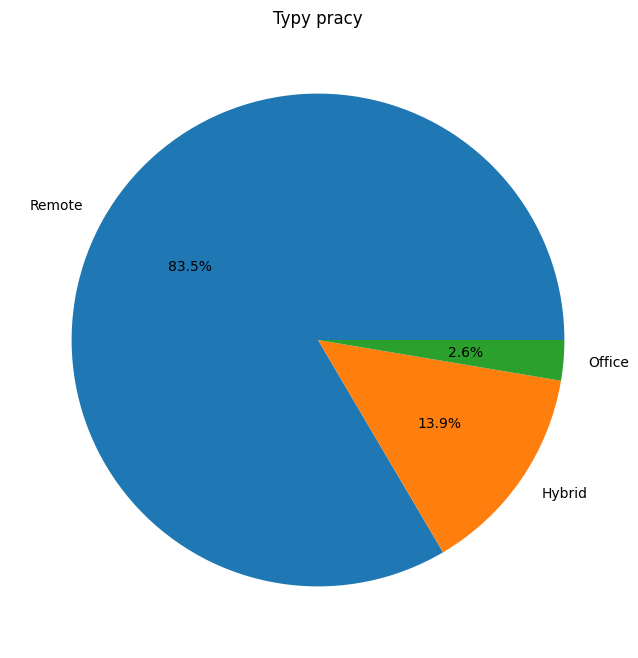

<Figure size 640x480 with 0 Axes>

In [1472]:
get_histogram(df, 'operating_mode_code', 'Typy pracy', encoder=mode_encoder)

## Histogram doświadczenia

Senior    2669
Mid       1766
Junior     139
Name: count, dtype: int64


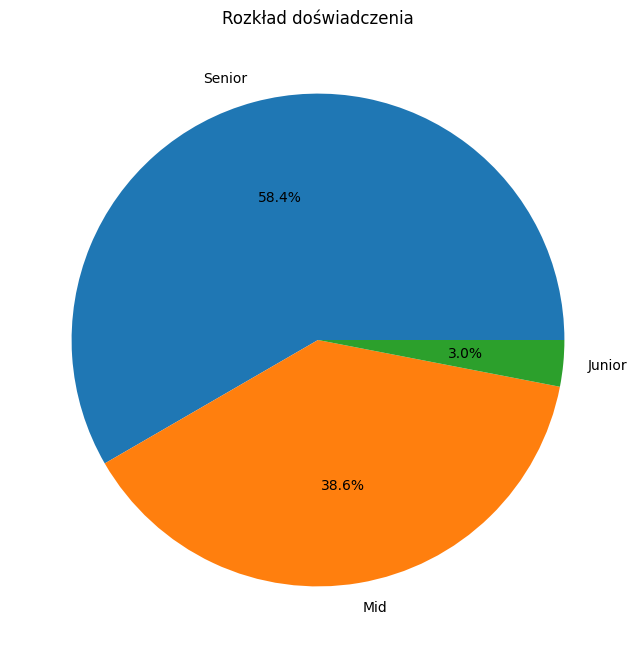

<Figure size 640x480 with 0 Axes>

In [1473]:
get_histogram(df, 'experience_code', title="Rozkład doświadczenia", label_x="", label_y="", encoder=exp_encoder)

# Rozkład zarobków na B2B

In [1474]:
def salary_distribution(data, exp, encoder=exp_encoder, color='skyblue'):
    exp_code = encoder.transform([exp])[0]
    df_filtered_b2b = data[(data["min_b2b"] > 0) & (data["max_b2b"] > 0) & (data["experience_code"] == exp_code)].copy()

    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z b2b: {len(df_filtered_b2b)}")

    df_filtered_b2b['avg_b2b'] = df_filtered_b2b[["min_b2b", "max_b2b"]].mean(axis=1)

    plt.figure(figsize=(20, 6))  # Adjust the size to accommodate two plots

    # First plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    sns.kdeplot(df_filtered_b2b['avg_b2b'], color=color)
    plt.title(f"Rozkład zarobków {exp}a na B2B")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a na B2B")
    plt.ylabel("Gęstość ofert")
    plt.grid(True)

    df_filtered_uop = data[(data["min_uop"] > 0) & (data["max_uop"] > 0) & (data["experience_code"] == exp_code)].copy()
    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z uop: {len(df_filtered_uop)}")
    df_filtered_uop['avg_uop'] = df_filtered_uop[["min_uop", "max_uop"]].mean(axis=1)

    # Second plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    sns.kdeplot(df_filtered_uop['avg_uop'], color=color)
    plt.title(f"Rozkład zarobków {exp}a na UOP")
    plt.ylabel("Gęstość ofert")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a na UOP")
    plt.grid(True)
    plt.show()
    plt.savefig(f"plots/rozkłady/rozklad_pensji_{exp}a.png")


Rozkład wynagrodzeń dla Mid, liczba ofert z b2b: 1491
Rozkład wynagrodzeń dla Mid, liczba ofert z uop: 681


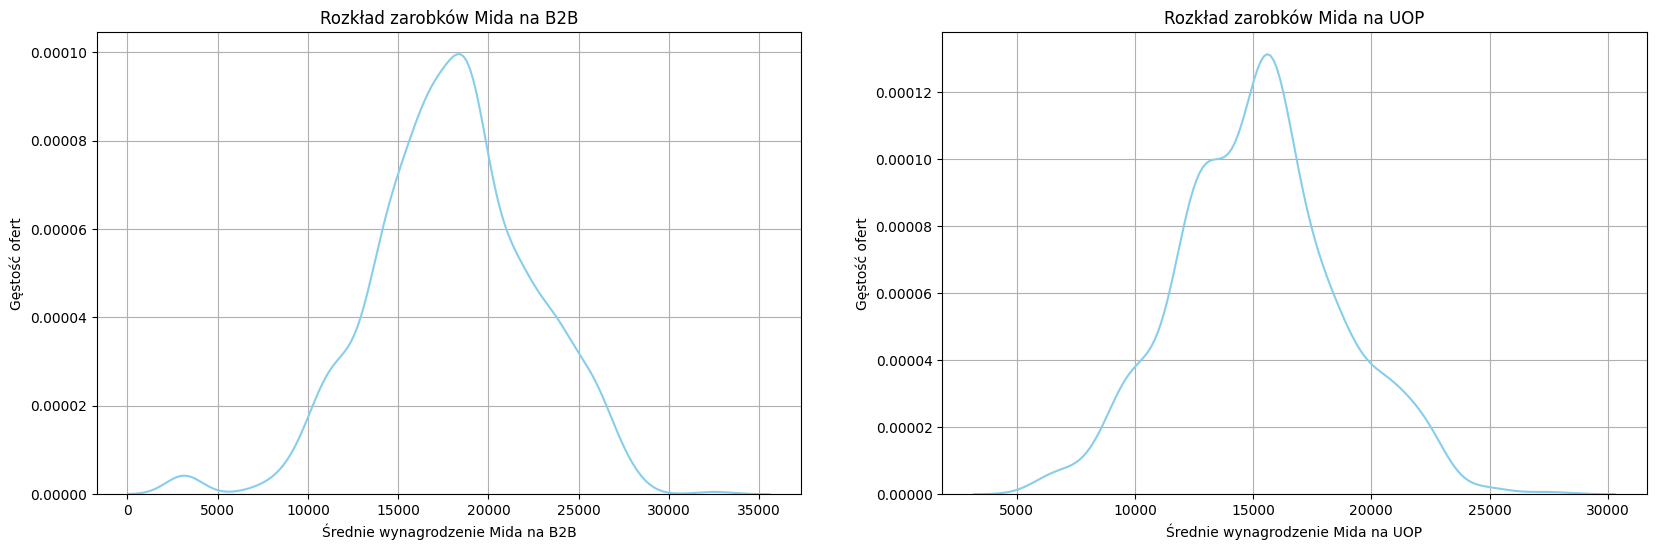

Rozkład wynagrodzeń dla Senior, liczba ofert z b2b: 2298
Rozkład wynagrodzeń dla Senior, liczba ofert z uop: 1114


<Figure size 640x480 with 0 Axes>

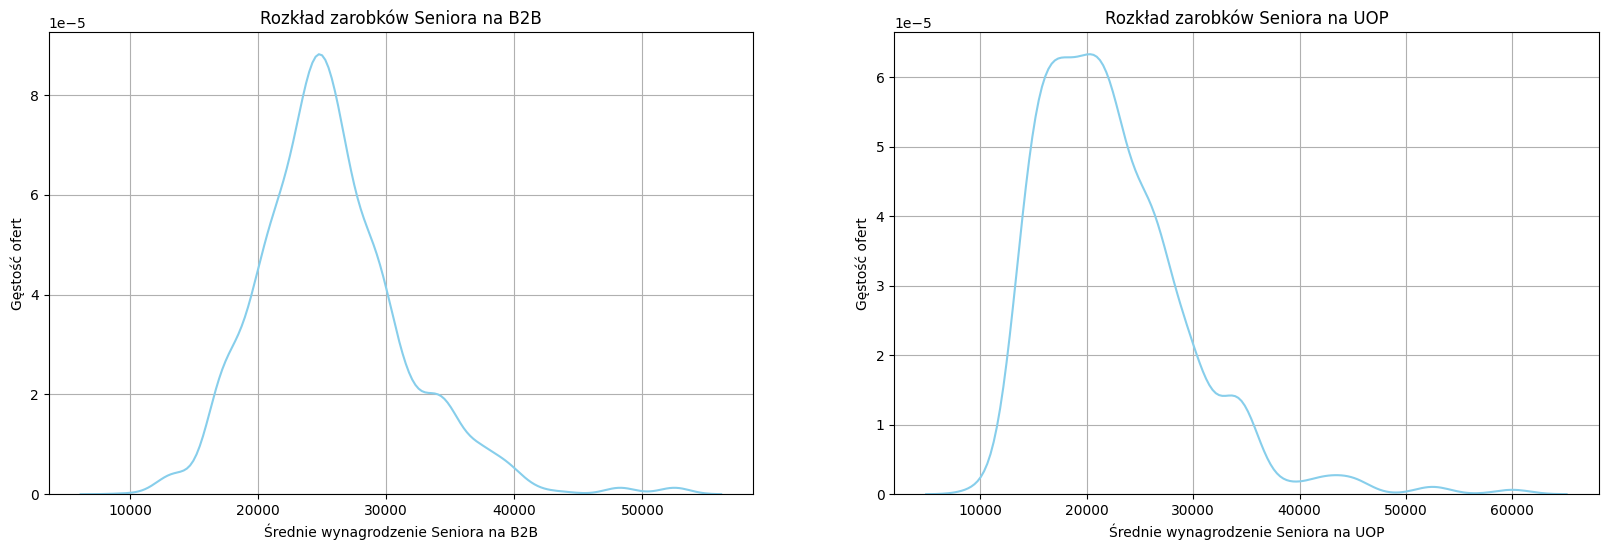

Rozkład wynagrodzeń dla Junior, liczba ofert z b2b: 101
Rozkład wynagrodzeń dla Junior, liczba ofert z uop: 58


<Figure size 640x480 with 0 Axes>

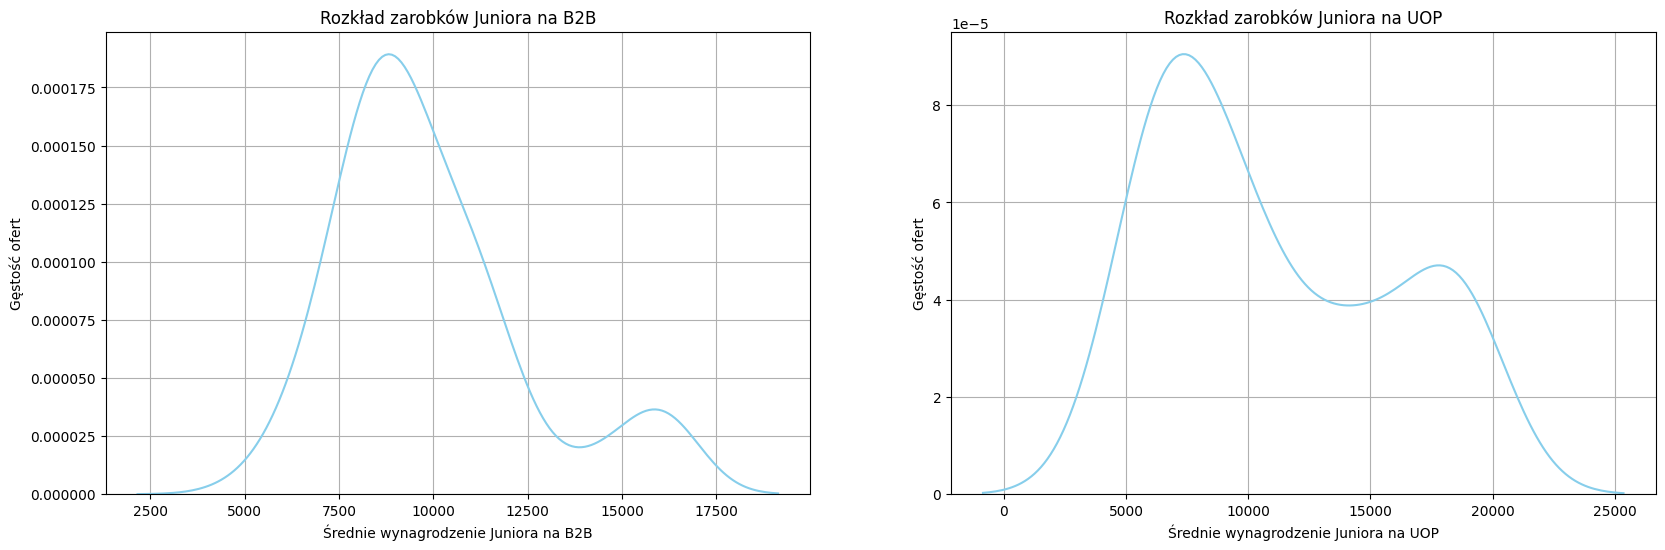

<Figure size 640x480 with 0 Axes>

In [1475]:
salary_distribution(df, "Mid")
salary_distribution(df, "Senior")
salary_distribution(df, "Junior")

# Rozkład popularności technologii

In [1476]:
def popularity(data, start_column, end_column, title, xlabel, ylabel, figsize=(22, 6), color='blue'):
    technologies = data.loc[:, start_column:end_column]

    sum_of_tech = technologies.sum().sort_values(ascending=False)

    plt.figure(figsize=figsize)
    sum_of_tech.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()
    plt.savefig(f"plots/rozkłady/popularne_technologie.png")


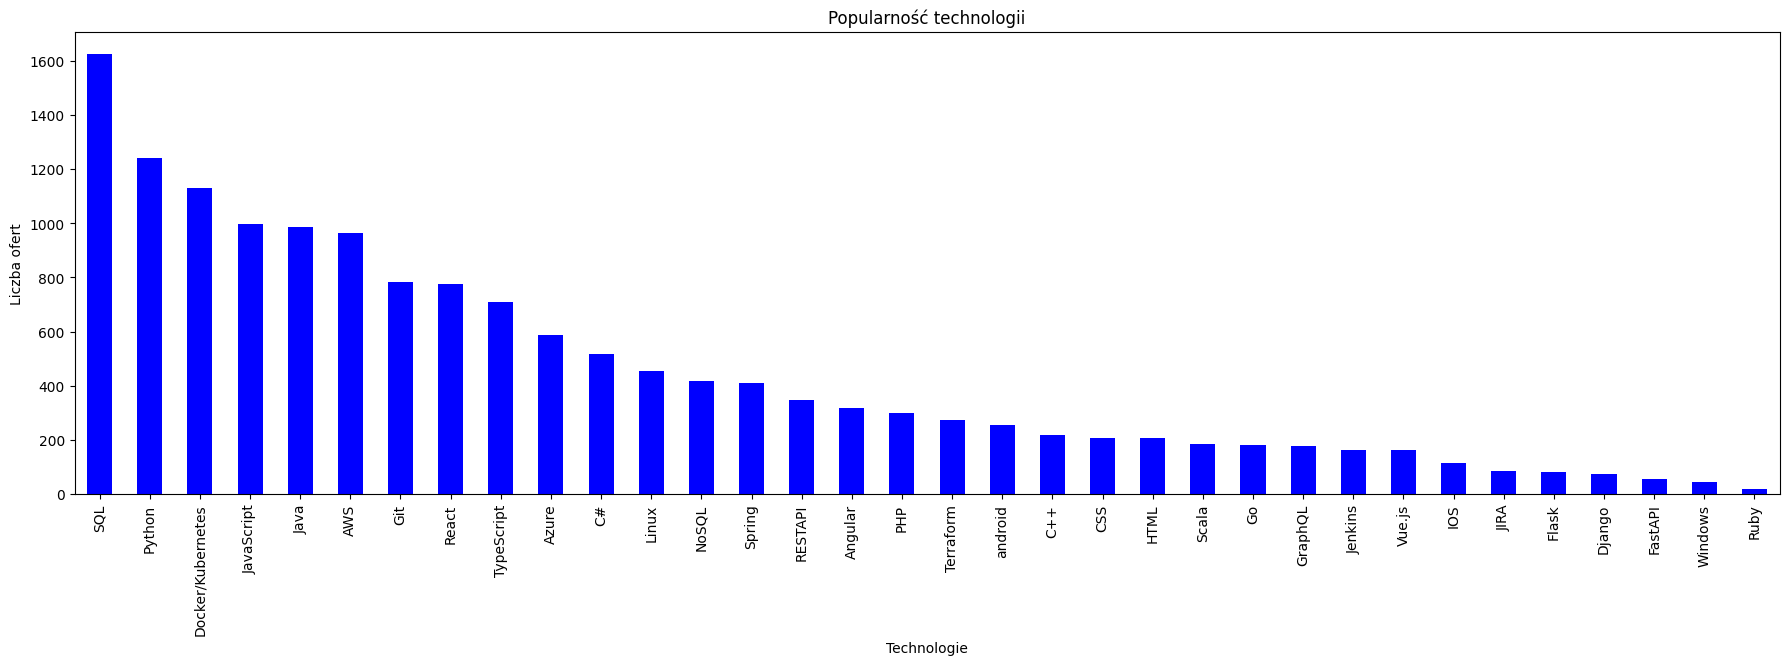

<Figure size 640x480 with 0 Axes>

In [1477]:
popularity(df, 'AWS', 'android', 'Popularność technologii', 'Technologie', 'Liczba ofert')

# Rozkład lokalizacji

Warszawa     827
Kraków       658
Wrocław      597
Gdańsk       494
Poznań       489
Katowice     327
Łódź         279
Rzeszów      191
Lublin       172
Bydgoszcz    116
Białystok     99
Toruń         68
Name: count, dtype: int64


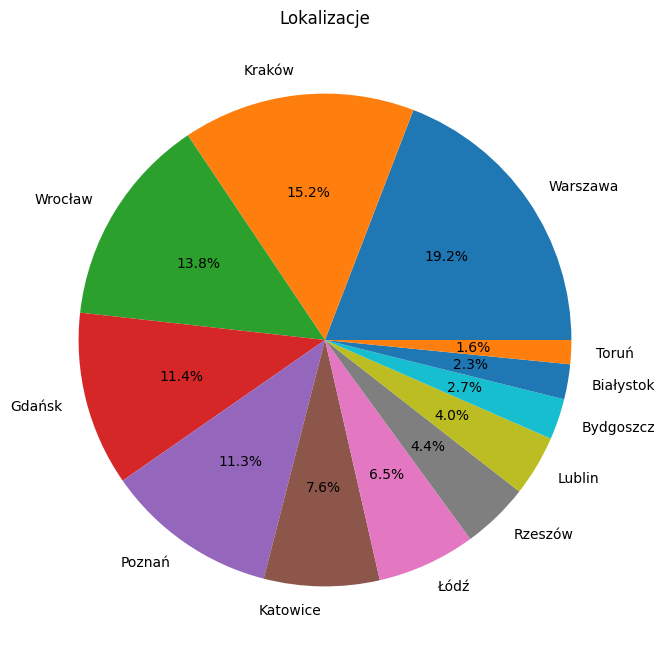

<Figure size 640x480 with 0 Axes>

In [1478]:
get_histogram(df, 'location_code', 'Lokalizacje', location_encoder, label_x="", label_y="")

Experience: 0
Warszawa     27
Wrocław      20
Katowice     15
Kraków       15
Gdańsk       14
Poznań       14
Łódź          6
Rzeszów       6
Toruń         5
Gliwice       5
Lublin        3
Białystok     2
Name: count, dtype: int64


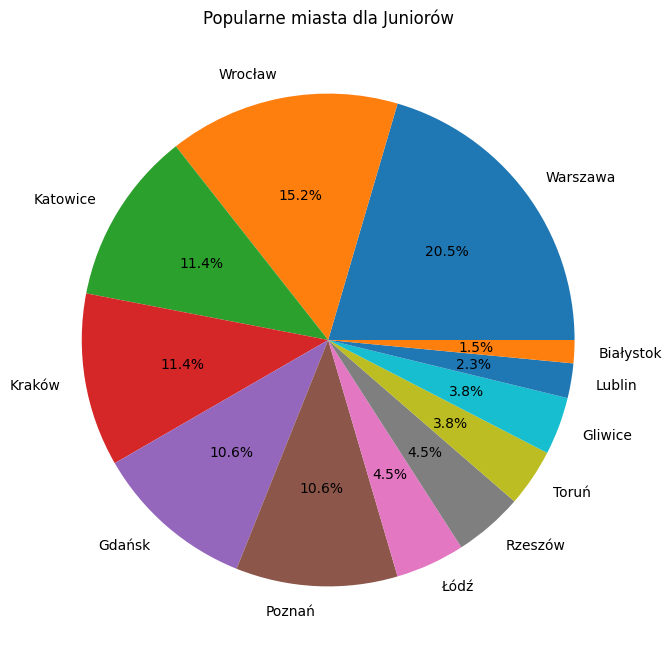

<Figure size 640x480 with 0 Axes>

In [1479]:
get_histogram(df, 'location_code', 'Popularne miasta dla Juniorów', location_encoder, label_x="", label_y="", is_specified=True, exp="Junior")

# Macierz korelacji techonlogii

Czy jakieś techonologie idą ze sobą w parze.


In [1480]:
def create_corr_plot(corr, title, size=(20,20)):
    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True,fmt=".2f", linecolor="lightgrey", linewidths=0.5, cmap="flare")
    sns.color_palette("flare", as_cmap=True)
    plt.title(title)
    plt.show()
    plt.savefig(f"plots/korelacje/{title}.png")

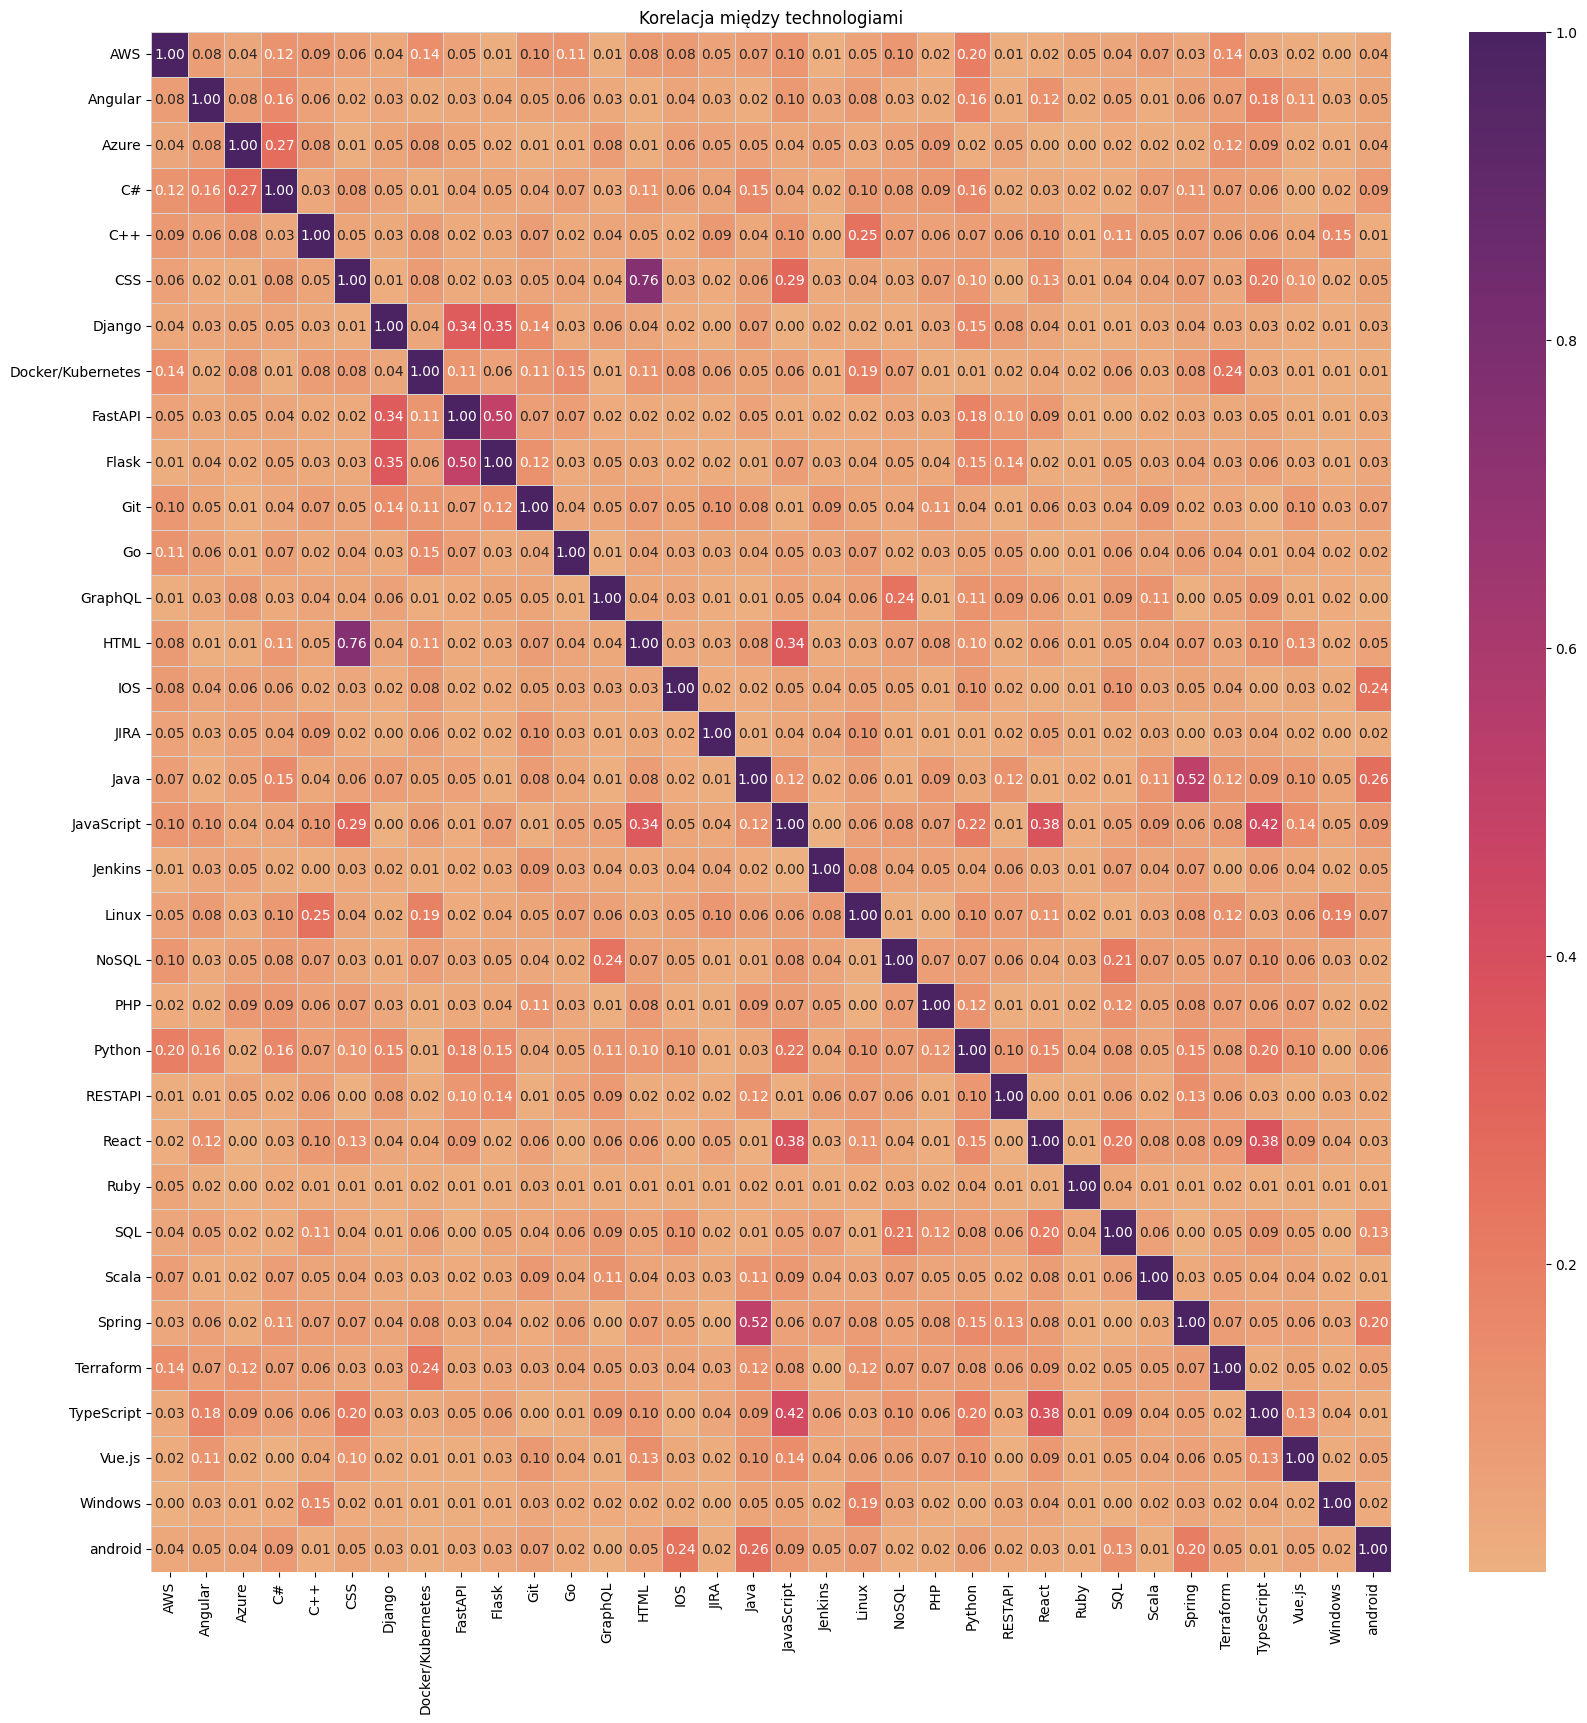

<Figure size 640x480 with 0 Axes>

In [1481]:
# Obliczenie korelacji między wybranymi kolumnami
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr = df[technologies].corr()
corr = corr.abs()
create_corr_plot(corr, 'Korelacja między technologiami')


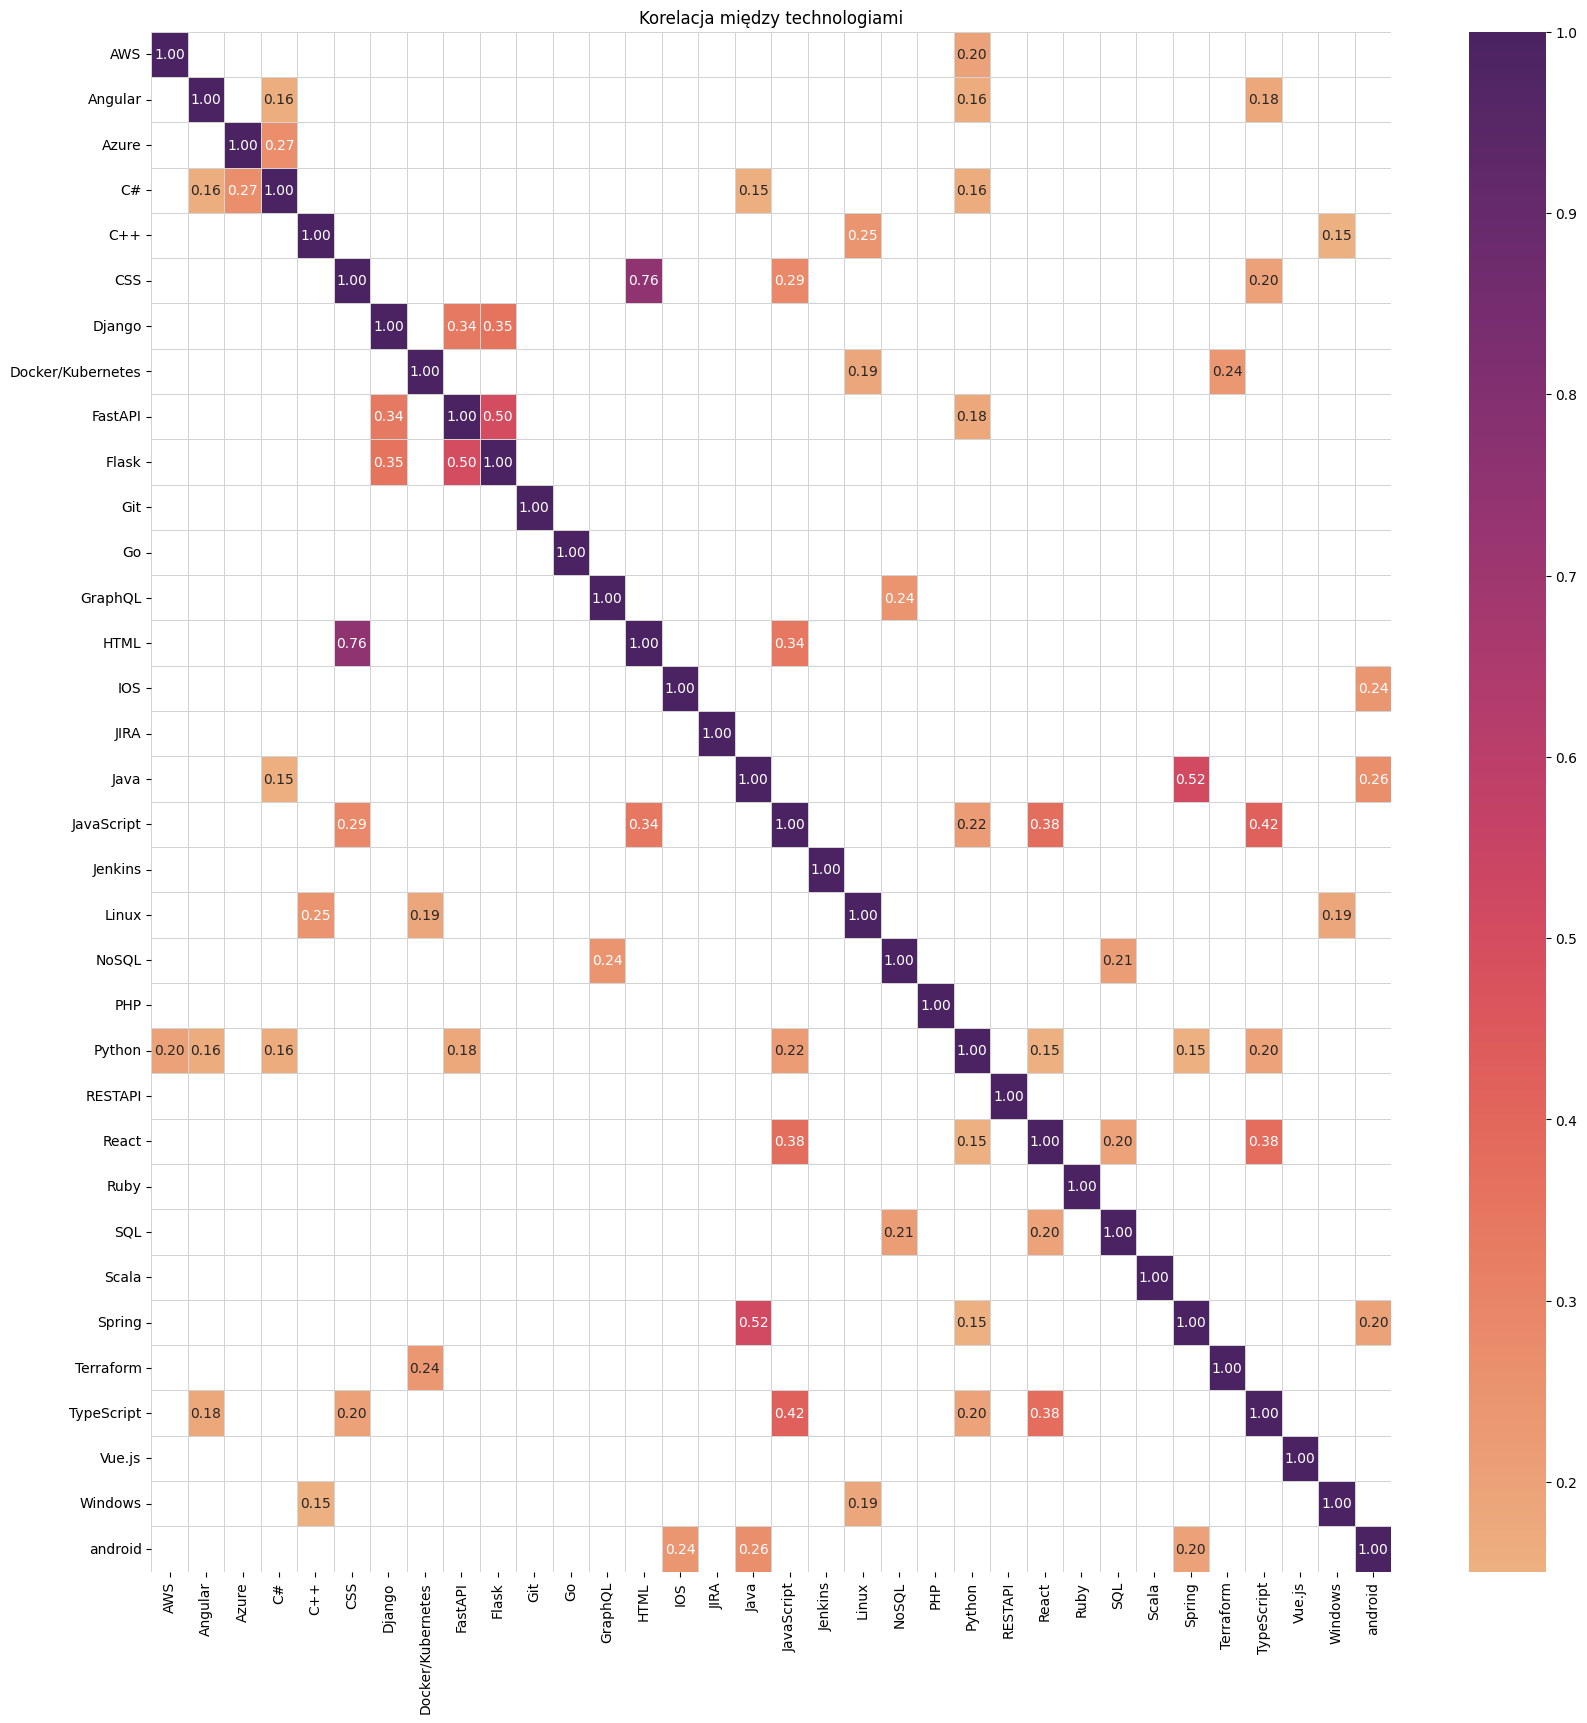

<Figure size 640x480 with 0 Axes>

In [1482]:
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr_matrix = df[technologies].corr().abs()

mask = corr_matrix > 0.15

filtered_corr = corr_matrix[mask]

create_corr_plot(filtered_corr, 'Korelacja między technologiami')

# Macierz korelacji wybranych zmiennych

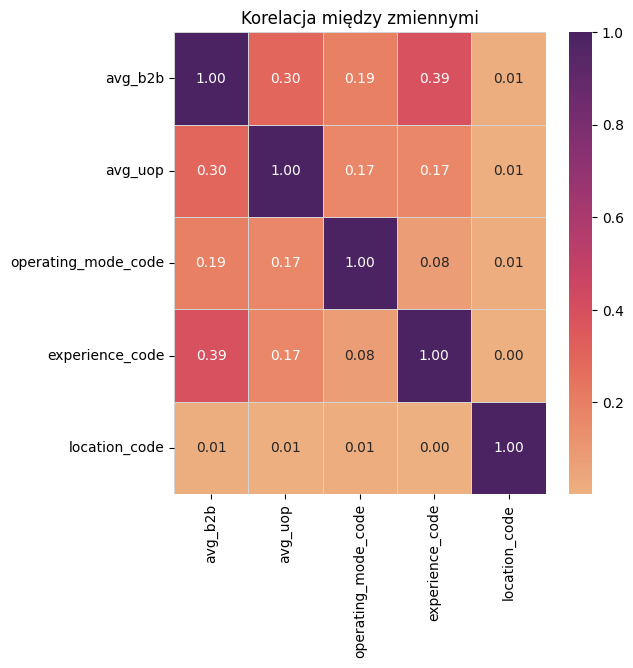

<Figure size 640x480 with 0 Axes>

In [1483]:
data["avg_b2b"] = data[["min_b2b", "max_b2b"]].mean(axis=1)
data["avg_uop"] = data[["min_uop", "max_uop"]].mean(axis=1)

vars = ["avg_b2b", "avg_uop", "operating_mode_code", "experience_code", "location_code"]

corr = data[vars].corr()
corr = corr.abs()

create_corr_plot(corr, 'Korelacja między zmiennymi', size=(6,6))



# Zarobki a technologie

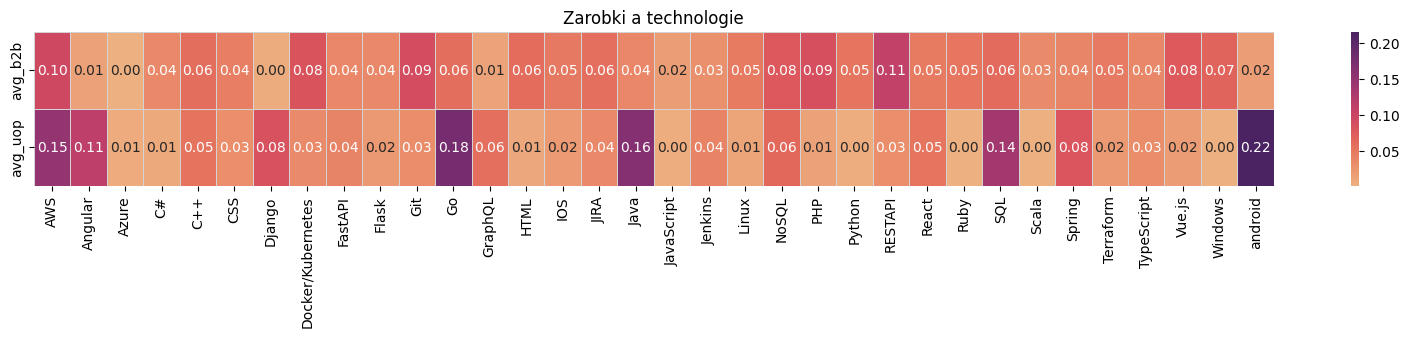

<Figure size 640x480 with 0 Axes>

In [1484]:
salaries = ["avg_b2b", "avg_uop"]
techs = data.loc[:, "AWS":"android"]

all_vars = salaries + list(techs.columns)
corr = data[all_vars].corr()
corr = corr.abs()  
corr = corr.loc[salaries, techs.columns] 

create_corr_plot(corr, "Zarobki a technologie", size=(20, 2))



# Korelacja technologii a lokalizacji

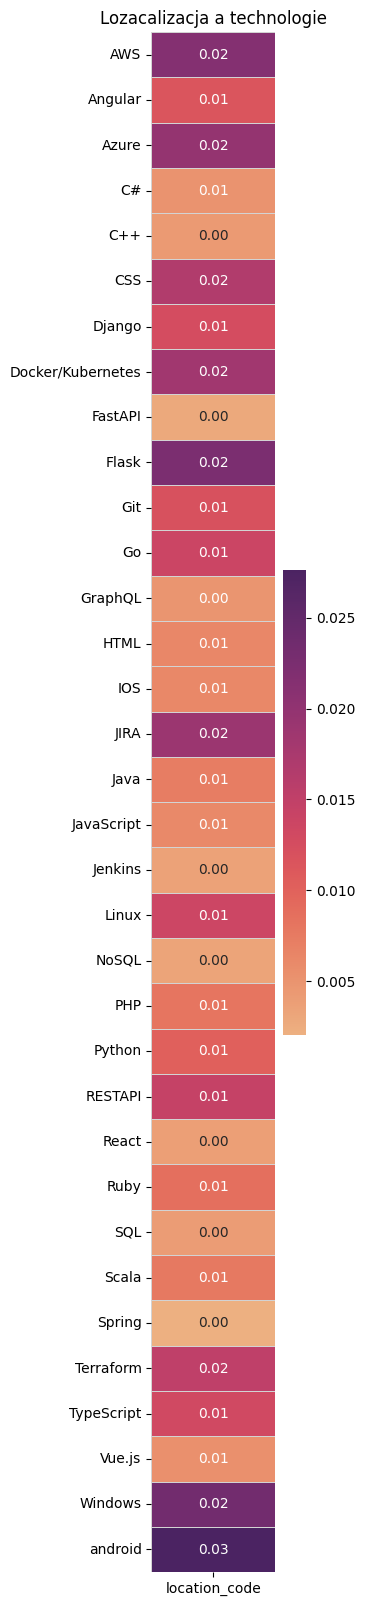

<Figure size 640x480 with 0 Axes>

In [1485]:
corr = data[["location_code"] + list(techs.columns)].corr()
corr = corr.abs()
corr = corr.loc[techs.columns, ["location_code"]]
create_corr_plot(corr, "Lozacalizacja a technologie", size=(2, 20))

# Przewidywanie zarobków na podstawie technologii

Proces znaczniemy od napisania funckji, która będzie filtrować dane na podstawie kilku rzeczy:
- technologii
- lokalizacji
- doświadczenia

In [1486]:
def filter_data(data, tech_stack=[], location=None, exp=None, other_col=[]):
    # Wybranie odpowiednich kolumn z doświadczeniem
    res = data
    if exp is not None:
        exp_code = exp_encoder.transform([exp])[0]
        res = data[data["experience_code"] == exp_code]

    if location is not None:
        # Wybranie odpowiednich kolumn z lokalizacją
        location_code = location_encoder.transform([location])[0]
        res = res[res["location_code"] == location_code]
    
    # Wybranie wierszy, które mają 1 dla kolumn w tech_stack
    if tech_stack != []:
        for tech in tech_stack:
            res = res[res[tech] == 1]
    else:
        tech_stack = data.loc[:, "AWS": "android"].columns.tolist()

    columns_to_keep = tech_stack + ["avg_b2b", "avg_uop", "operating_mode_code", "experience_code", "location_code"] + other_col 
    return res[columns_to_keep]


# Podział danych na oferty pracy uop i b2b

Kolejnym krokiem jest podział danych na oferty pracy uop i b2b oraz usunięcie nie potrzebnych kolumn w zalezności od
kontraktu.

In [1487]:
def prepare_data_sets(tech_stack):
    filtered_data_b2b = filter_data(data[data["min_b2b"]>0], tech_stack=tech_stack)
    filtered_data_uop = filter_data(data[data["min_uop"]>0], tech_stack=tech_stack)
    return filtered_data_b2b.drop(columns=["avg_uop"]), filtered_data_uop.drop(columns=["avg_b2b"])

# Przyogowanie danych do modelu

`Features`: to są nasze dane wejściowe, które będą używane do przewidywania zarobków.

_początkowo miały to być tylko technologie, ale stwierdziłem, ze lepiej bardziej rozwinąć model_

`Target`: to są nasze dane wyjściowe, które chcemy przewidzieć.

Zwracamy dane do trenowania modelu oraz dane do testowania modelu. Zamierzam przetestować 
dla `test_size=0.2` oraz `test_size=0.4` i zobaczyć jaki podział jest lepszy.

In [1488]:
def prepare_test_train_sets(data, value_to_predict: str, test_size: float=0.2):
    features = data.drop(columns=[value_to_predict], axis=1)
    target = data[value_to_predict]
    x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=test_size,random_state=42)
    return x_train, x_test, y_train, y_test
  

# Przygotowanie modeli

Wybrałem Regresje Liniową, Las losowy i drzewko decyzji.

**Dlaczego?**

- Regresja liniowa: jest to najprostszy model regresji, który zakłada liniową zależność między zmiennymi i pojawiła się na zajęciach.

- Random Forest: podobno skuteczny model (z polecenia znajomego), który jest złożeniem wielu drzew decyzyjnych.

- Drzewo decyzyjne: jest to najprostszy model, który zakłada, że dane są liniowe.


Nie wykluczam, ze będę testował inne modele, ale na razie zacznę od tych trzech.

Inne modele, które mogę przetestować:

- Lasso
- Ridge
- ElasticNet

In [1489]:
models = {
    'Linear_Regression':{
        'model':LinearRegression(),
        'params':{
            
        }
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[2,4,6,8,10],
            'random_state':[0,42],
            'min_samples_split':[2,5,10,20]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(),
        'params':{
            'n_estimators':[10,30,20,50,80]
        }
    },
    'Ridge':{
        'model':Ridge(),
        'params':{
            'alpha':[0.1,0.5,1,2,5,10]
        }
    },
    'ElasticNet':{
        'model':ElasticNet(),
        'params':{
            'alpha':[0.1,0.5,1,2,5,10],
            'l1_ratio':[0.1,0.5,1]
        }
    }
}

In [1490]:
def choosing_proper_params_for_models(models, x_train, y_train):
    scores=[]

    for name, value in models.items():
        clf = GridSearchCV(value['model'], value['params'], cv=5, scoring='neg_mean_squared_error')
        clf.fit(x_train,y_train)
        
        scores.append({
            'Model':name,
            'Params':clf.best_params_,
            'MSE(-ve)':clf.best_score_
        })
    pd.DataFrame(scores)    

# Wybieramy najlepszy model

Tutaj to zalezy od danych wejściowych, czasami zwraca Regresje Liniową, a czasami Random Forest.

In [1491]:
def get_best_model(models, x_train, x_test, y_train, y_test, short=True):
    score = float('-inf')
    best_model = None
    choosing_proper_params_for_models(models, x_train, y_train)
    for value in models.values():
        tmp_model = value["model"]
        tmp_model.fit(x_train,y_train)
        score_ = tmp_model.score(x_test,y_test)
        if score_ > score:
            score = score_
            best_model = tmp_model
        y_pred = tmp_model.predict(x_test)
        if not short:
            print(f'Model: {tmp_model.__class__.__name__}')
            print("Mean Squared Error :",mean_squared_error(y_test,y_pred).round(2))
            print("Mean Absolute Error :",mean_absolute_error(y_test,y_pred).round(2))
            print("Root Mean Squared Error :", root_mean_squared_error(y_test,y_pred).round(2))
            print("R^2 Score :",r2_score(y_test,y_pred))
        
    return best_model   

# Sklejenie wszystkich kroków w jedno

In [1492]:
def predict_salary(models, **params): 
    non_zero_b2b, non_zero_uop = prepare_data_sets(tech_stack=params["tech_stack"])
    
    def choose_contract(contract):
        contract = contract.lower()
        if contract == "b2b":
            return prepare_test_train_sets(non_zero_b2b, "avg_b2b", params["test_size"])
        else:
            return prepare_test_train_sets(non_zero_uop, "avg_uop", params["test_size"])
        
    x_train, x_test, y_train, y_test = choose_contract(params["contract"])
    best_model = get_best_model(models, x_train, x_test, y_train, y_test, short=False)

    # bierzemy dane juz z całego zbioru
    new_data1 = filter_data(data, location=params["location"], exp=params["exp"], tech_stack=params["tech_stack"])
    
    salary = best_model.predict(new_data1.drop(columns=["avg_b2b", "avg_uop"])).mean().round(2)
    print(f"Wybrany model: {best_model.__class__.__name__}")
    print(f"Przewidywane zarobki dla {params['exp']}a znającego {params['tech_stack']} w lokalizacji {params['location']} na umowie {params['contract']} to: {salary} PLN\n")

In [1493]:
params = {
    "location": "Warszawa",
    "exp": "Mid",
    "test_size": 0.2,
    "contract": "b2b",
    "tech_stack": ["Go" ]
}

params1 = {
    "location": "Warszawa",
    "exp": "Junior",
    "test_size": 0.2,
    "contract": "uop",
    "tech_stack": ["Python"]
}

predict_salary(models, **params1)
predict_salary(models, **params)


Model: LinearRegression
Mean Squared Error : 45245710.08
Mean Absolute Error : 5166.89
Root Mean Squared Error : 6726.49
R^2 Score : 0.3369672399449042
Model: DecisionTreeRegressor
Mean Squared Error : 47109018.7
Mean Absolute Error : 5432.75
Root Mean Squared Error : 6863.6
R^2 Score : 0.3096622279665523
Model: RandomForestRegressor
Mean Squared Error : 45980466.68
Mean Absolute Error : 5298.04
Root Mean Squared Error : 6780.89
R^2 Score : 0.3262000823658374
Model: Ridge
Mean Squared Error : 45294248.37
Mean Absolute Error : 5171.85
Root Mean Squared Error : 6730.1
R^2 Score : 0.3362559576872992
Model: ElasticNet
Mean Squared Error : 54763208.46
Mean Absolute Error : 5882.51
Root Mean Squared Error : 7400.22
R^2 Score : 0.19749737188218164
Wybrany model: LinearRegression
Przewidywane zarobki dla Juniora znającego ['Python'] w lokalizacji Warszawa na umowie uop to: 9117.8 PLN

Model: LinearRegression
Mean Squared Error : 15302227.05
Mean Absolute Error : 3015.83
Root Mean Squared Error

# Analiza wyników dla przykładowych danych